### Notebook for testing the LLama2-7B model. We also load and parse the output from the model here

In [1]:
import sys
from tqdm.notebook import tqdm

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers
import torch

/Users/z003yzhj/Desktop/Projects/TabNER/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load model directly

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf")


In [21]:
pipeline = transformers.pipeline("text-generation",
                                model=model,
                                tokenizer=tokenizer,
                                torch_dtype=torch.float16,
                                device_map="auto",
                                )

In [22]:
prompt = """You are an NER expert. Extract entities from the input table using the following types: Activity, Organisation, ArchitecturalStructure, Event, Place, Person, Work. 
     If the type of the entity is not one of the types above, please use type: MISC. The output is a list with dictionary for every entity in the following format: 
     [{"entity": Entity, "type": Type, "cell_index": [x,y]}]. Cell index should be one list [x,y] where x is the row number and y is the column number.
     The table header has index -1, the table content with entities start from index [0,0].
         Example table:
         Draw,Artist,First song (original artist),Draw,Second song (original artist),Result
         1,Mark Evans," Rock Your Body " ( Justin Timberlake ),5," I Don't Want to Talk About It " ( Rod Stewart ),Safe,
         Output:
         [{"entity": "Mark Evans",   "type": "Person",   "cell_index": [0, 1] },
         {"entity": "Justin Timberlake",    "type": "Person",    "cell_index": [0, 2]},
         {"entity": "Rock Your Body",    "type": "Work",    "cell_index": [0, 2]}]
         
  Table:
 Author|Title|Principal Character(s)
 Matthew Baugh|"Tournament of the Treasure"|Steve Costigan , The Black Coats , Townsend Harper
 Nicholas Boving|"Wings of Fear"|Harry Dickson , Bulldog Drummond
 Robert Darvel|"The Man With the Double Heart"|The Nyctalope
 Matthew Dennion|"The Treasure of Everlasting Life"|Allan Quatermain , Dr. Loveless , The Black Coats
 Win Scott Eckert|"Violet's Lament"|Lady Blakeney , The Black Coats
 Martin Gately|"Wolf at the Door of Time"|Doctor Omega , Moses Nebogipfel , The Nyctalope
 Travis Hiltz|"What Lurks in Romney Marsh?"|Doctor Omega , Doctor Syn
 Paul Hugli|"As Time Goes By..."|Doctor Omega , Rick Blaine?
 Output:
 """

In [ ]:
sequences = pipeline(
        prompt,
        do_sample=True,
        top_k=10,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        max_length=4000,
        )

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
for seq in sequences:
    print(f"{seq['generated_text']}")

## Parsing Llama output and evaluate

In [1]:
import torch
import re
import json
import os
import sys
sys.path.append("../")

In [2]:
from utils import tab_to_csv, get_correct_anno, eval_llama_output, llm_responce
from utils import parse_output, parse_entities
from ner_prompting import calc_results

/Users/z003yzhj/Desktop/Projects/TabNER/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


False


In [3]:
seed_nr = 42
generator = torch.Generator().manual_seed(seed_nr)

In [4]:
data_path="../data/final_NER_labeled_dataset.csv"
with open(data_path, 'r') as f:
    ner_tables = json.load(f) 

In [5]:
train_set, test_set = torch.utils.data.random_split(ner_tables, [49271, 2000], generator=generator)

In [6]:
labels_dict = {  
            'Activity': 1,
            'Organisation': 2,
            'ArchitecturalStructure': 3,
            'Event': 4,
            'Place': 5,
            'Person': 6,
            'Work': 7,
                }
labels_dict_rev={v:k for k,v in labels_dict.items()}
print(labels_dict)

{'Activity': 1, 'Organisation': 2, 'ArchitecturalStructure': 3, 'Event': 4, 'Place': 5, 'Person': 6, 'Work': 7}


In [7]:
# Here are printed all the entities which were incomplete to be evaluated.
parsed_output_llama0 = parse_output("Llama", "log_file_llama7b_3_filtered_False.txt")

{"entity": "JAM", "type": "Place",'}
{"entity'}
{"entity": "Anonymous Content", "type": "Organisation", "cell'}
{"entity": "'}
{"entity'}
{"entity": "Take That", "type'}
{"entity": "Pittsburgh Pirates", "type": "Organisation", "cell_index": [16'}
{"entity": "World War II", "type": "Event", "cell_index": [3, '}
{"entity": "Narumi'}
{"entity": "Anna Meares", "type":'}
{"entity": "Sunday, April '}
{"entity": "D'}
{"entity": "CM Airlines", "type": "Organisation", "cell_index": [11, 0]'}
{"entity": "RUS",'}
{"entity":'}
{"entity": "AUS", "type": "Place",'}
{"entity": "Plus Communication", "'}
{"entity": "Nairobi-Jomo Kenyatta", "type": "ArchitecturalStructure",'}
{"entity": "SWE'}
{"entity": "ROU", "type": "Organisation", "cell_index'}
{"entity": "USA", "'}
{"entity": "Brazil", "type": "Place'}
{"entity": "Robert Satcher", "type": "Person", "cell_index": [13, 2]  Table:#|Image|Name Birth date|Comment|Missions (Launch date)1||Sally Ride June 26, 1951|First American woman in space|STS-7 (June

{"entity": "Germany", "type": "Place", "cell'}
{"entity": "ASV Dach'}
{"entity'}
{"'}
{"entity": "Amore & Vita-McDonald''}
{"entity": "Leningrad'}
{"entity": "Cleveland", "type": "Organisation", "cell_index": ['}
{"entity": "Andy Turner", "type": "Person", "cell_index": [7, 2]'}
{"entity": "1989", "'}
{"entity": "Seks, droga, nasilje i strah / Balkan Hor'}
{"entity": "Davis Wade Stadium", "type": "ArchitecturalStructure'}
{"entity": "Roy "Shrimp" Worters", "type": "Person", "cell_index": [5, 0]}
{"entity": "Ottawa Senators", "type": "Organ'}
{"entity": "Memphis State", "type":'}
{"entity": "ITA", "type": "Place", "cell_index'}
{"entity": "'}
{"entity": "COL", "type": "Place", "cell_index":'}
{"entity":'}
{"entity": "K'}
{"'}
{"entity": "11 September 2007'}
{"entity": "Bottle Creek Indian Mounds", "type": "Place", "'}
{"entity": "Marianne Vos'}
{"entity": "Tejay van Garderen", "type": "Person",'}
{"entity": "Valeri Ponomarenko", "type": "Person'}
{"entity": "2'}
{"entity": "Lachlan Mort

In [8]:
len(parsed_output_llama0)

600

In [9]:
len(parsed_output_llama0["5460482-9"])

80

In [10]:
types = []
for tab, values in parsed_output_llama0.items():
    for el in values:
        for key, val in el.items():
            if key =="type":
                types.append(val)

In [11]:
len(set(types))

66

In [12]:
dict_results = eval_llama_output(ner_tables, test_set.indices, parsed_output_llama0, labels_dict, filtered=False)

/Users/z003yzhj/Desktop/Projects/tabner/notebooks/../utils.py:336: FutureWarning: Possible nested set at position 1
  span_search = re.search(entity_text, cell_text)


In [13]:
p, r, f1, f1_dict=calc_results(dict_results["all_gt_annotations"], dict_results["all_predict_annotations"], class_wise=True)

In [14]:
p, r, f1, f1_dict

(0.7772983114446529,
 0.25104526449736414,
 0.3795172445380846,
 defaultdict(float,
             {5: 0.4351037636299684,
              1: 0.30177514792899407,
              6: 0.3821468926553672,
              2: 0.3667664670658683,
              3: 0.3544575725026853,
              7: 0.15345911949685534,
              4: 0.34285714285714286}))

In [ ]:
for key, val in dict_results.items():
    if key == ("predicted_label" or "true_label"):
        print(key, len(val), len(val)/total_preds)
    else:
        
        print(key, len(set(val)), len(set(val))/total_preds)

In [30]:
true_label = []
predicted_label = []

labels_dict["MISC"] = 10

for i in range(len(dict_results["all_predict_conf"])):
    for el in all_predict_conf[i]:
        for tup in dict_results["all_gt_annotations"][i]:
            if el[0:4] == tup[0:4]:
                true_label.append(tup[4])
                predicted_label.append(el[4])

for i, el in enumerate(predicted_label):
    if el == 0:
        predicted_label[i] = 10

### Plotting Confusion Matrix for the output

In [31]:
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

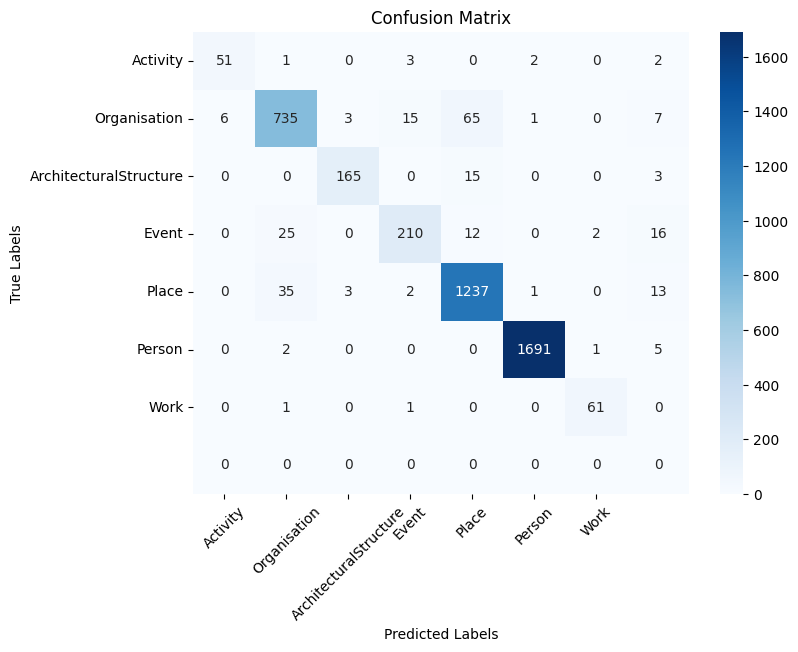

In [32]:
cm = confusion_matrix(true_label,predicted_label)
#print(cm)
# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_dict_rev.values(), yticklabels=labels_dict_rev.values())
plt.xticks(rotation=45)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.savefig("../output/plots/filtered/cm_llama_3_sim.png",bbox_inches = "tight")